### **Project One: Small Language Model (Predictive Text)**
Use an http API to populate data to a complex data structure
- develop a small computational experiment
- write a well-organized, self-contained, easy-to-read computational notebook
- present a visualization of the experimental results in graphical form

21-26 February, David Lu

In [ ]:
import re
import random
import requests
import networkx as nx
import collections
import matplotlib.pyplot as plt

#### **Part One: Input**

The input text for this model is the preface to Livy's *The Early History of Rome (Books 1-5)*, as translated by Aubrey de Sélincourt. The text has been uploaded to the project's Github directory for easy access, and simple Markdown formatting has been applied for improved readability.

Getting started, the  full Markdown text is retrieved with help from the `requests` library.
Next, the text is separated into its constituent words, which are the basic unit of manipulation of the model.


In [ ]:
address = 'https://raw.githubusercontent.com/zhdavidlu/cap-comp215/main/projects/livy.md'

response = requests.get(address)
text = response.text  # full markdown text

remove = re.sub(r'.*\n\n', '', text, count = 1)  # remove the heading
replace = re.sub(r'\n', ' ', remove)             # replace line breaks with spaces

words = replace.split()  # split the text into a list of words
words[:9]  # show the first nine words, for a sense of what the list looks like

['The', 'task', 'of', 'writing', 'a', 'history', 'of', 'our', 'nation']

#### **Part Two: Restructuring**

The prediction mechanism of the model is extremely simple: provided a pair of consecutive words from the input, the prediction is taken to be the next word to appear after the pair. Importantly, if the pair appears more than once in the input, then the prediction will be a random selection from the various words to follow the pair throughout the text.

To make this selection in a timely manner, the word or words that follow any given pair needs to be retrieved efficiently. This is achieved, as was suggested, by a combination of the `defaultdict` sub-class and the "sliding-window algorithm". Each unique pair of consecutive words is placed within the dictionary `dictionnaire` as a key, and the word or list of words which follow are their corresponding values.

In [ ]:
dictionnaire = collections.defaultdict(list)
triplets = [((words[i], words[i+1]), words[i+2]) for i in range(len(words)-2)]  # "sliding window algorithm"

for k,v in triplets:
    dictionnaire[k].append(v)

list(dictionnaire.items())[:3]  # the first three entries in the dictionary

[(('The', 'task'), ['of']),
 (('task', 'of'), ['writing']),
 (('of', 'writing'), ['a'])]

#### **Part Three: Making Predictions**

A relatively straightforward implementation of the aforementioned prediction mechanism.

In [ ]:
# Helper functions

# Picks the first two words of a random sentence from the
# text to be the starting point for the model

def random_start (words):

    while True:
        random_number = random.randrange(0, len(words)-1)
        if words[random_number][-1] == '.': break

    return (words[random_number+1], words[random_number+2])


# Appends an ellipsis to sequences that end midway
# through a sentence to indicate incompletion

def append_ellipsis (line):

    if not line.endswith((';', '.')):
        line = f'{line}...'

    return line


# Breaks up very long lines of text into multiple shorter ones
# to improve readability (default width ~ 65 chars)

def break_line (line, linewidth = 65):

    if len(line) < (5/4)*linewidth:
        return line

    else:
        formatted_line = []
        former = 0
        additional_characters = 0

        for index in range(linewidth, len(line), linewidth):
            index += additional_characters

            while index < len(line) and line[index] != ' ':
                index += 1
                additional_characters += 1

            formatted_line.append(line[former:index] + '\n')
            former = index + 1

        formatted_line.append(line[former:])

    return ''.join(formatted_line)

In [ ]:
# Top-level / User-oriented function 1
def write_words (words, table, num_words = 12):

    words_in = random_start(words)
    word_sequence = list(words_in)

    for i in range(num_words):
        word_out = random.choice(table[words_in])
        words_in = (words_in[1], word_out)
        word_sequence.append(word_out)

    return append_ellipsis(' '.join(word_sequence))

# Top-level / User-oriented function 2
def write_sentences (words, table, num_sentences = 2):

    sentence_count = 0
    words_in = random_start(words)
    word_sequence = list(words_in)

    while sentence_count < num_sentences:
        word_out = random.choice(table[words_in])
        words_in = (words_in[1], word_out)
        word_sequence.append(word_out)

        if word_out[-1] == '.':
            sentence_count += 1

    return break_line(' '.join(word_sequence))

In [ ]:
some_words = write_words(words, dictionnaire)
some_sentences = write_sentences(words, dictionnaire)

print(some_words)
print()
print(some_sentences)

I shall find antiquity a rewarding study, if only because, while I am aware...

I shall pass unnoticed amongst them; if so, I must comfort myself
with the Eneti, who had been driven out of Paphlagonia and, having
lost their leader Latinus. Turnus and his brother were in the river.



#### **Addendum: Visualisation**

It must be first stated that the layout of the nodes into positions familiar to us was made possible by the `hierarchy_pos` function, written by Joel Miller for the [*EoN*](https://github.com/springer-math/Mathematics-of-Epidemics-on-Networks/tree/master) module, the accompaniment to *Mathematics of Epidemics on Networks,* by Kiss, Miller, and Simon. Out of an excess of laziness, for I have no experience installing packages into Colab, its defintion  has been reproduced below from [source](https://epidemicsonnetworks.readthedocs.io/en/latest/_modules/EoN/auxiliary.html#hierarchy_pos) without change.

The visualisation here takes the form of a simple directed graph representation of the prediction mechanism in action. Each word is represented by a node, and two nodes are connected by a directed edge if one follows the other and its parent in the text.

\begin{align*}
    b \Rightarrow c \quad\text{if} \quad &\text{there exists}\:\: (a,b,c) \:\:\text{in the model input} \\
    &\text{where parent}(b) = a
\end{align*}

In [ ]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5):

    '''
    If the graph is a tree this will return the positions to plot this in a
    hierarchical layout.

    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.

    We include this because it may be useful for plotting transmission trees,
    and there is currently no networkx equivalent (though it may be coming soon).

    There are two basic approaches we think of to allocate the horizontal
    location of a node.

    - Top down: we allocate horizontal space to a node.  Then its ``k``
      descendants split up that horizontal space equally.  This tends to result
      in overlapping nodes when some have many descendants.
    - Bottom up: we allocate horizontal space to each leaf node.  A node at a
      higher level gets the entire space allocated to its descendant leaves.
      Based on this, leaf nodes at higher levels get the same space as leaf
      nodes very deep in the tree.

    We use use both of these approaches simultaneously with ``leaf_vs_root_factor``
    determining how much of the horizontal space is based on the bottom up
    or top down approaches.  ``0`` gives pure bottom up, while 1 gives pure top
    down.


    :Arguments:

    **G** the graph (must be a tree)

    **root** the root node of the tree
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    **width** horizontal space allocated for this branch - avoids overlap with other branches

    **vert_gap** gap between levels of hierarchy

    **vert_loc** vertical location of root

    **leaf_vs_root_factor**

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0,
                    xcenter = 0.5, rootpos = None,
                    leafpos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = list(G.neighbors(root))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx,
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap,
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
#        pos[root] = (leftmost + (leaf_count-1)*dx/2., vert_loc)
#        print(leaf_count)
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])
    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width,
                                                    leafdx=width*1./leafcount,
                                                    vert_gap=vert_gap,
                                                    vert_loc = vert_loc,
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1])
#    pos = {node:(leaf_vs_root_factor*x1+(1-leaf_vs_root_factor)*x2, y1) for ((x1,y1), (x2,y2)) in (leafpos[node], rootpos[node]) for node in rootpos}
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/xmax, pos[node][1])
    return pos

In [ ]:
demo_line = 'I shall find antiquity'

def draw_figure (all, subset, complement):

    positions = hierarchy_pos(all)

    edge_style_common = {'node_size': 750, 'width': 4, 'arrowstyle': '->', 'arrowsize': 10}
    nx.draw_networkx_edges(subset, positions, edge_color='tab:blue', alpha=0.8, **edge_style_common)
    nx.draw_networkx_edges(complement, positions, alpha=0.2, **edge_style_common)

    node_style = {'node_size': 750, 'node_shape': 'none'}
    nx.draw_networkx_nodes(all, positions, **node_style)

    node_labels = {node: f'{node}' for node in all.nodes()}
    label_style = {'labels': node_labels, 'font_color': 'black', 'font_size': 10}
    nx.draw_networkx_labels(all, positions, **label_style)

    ax = plt.gca()
    plt.tight_layout()
    plt.axis("off")
    plt.show()


def visualise_mechanism (line, table):

    words = line.split()
    nodes = [words[0], words[1]]
    edges = [(words[0], words[1])]

    for i in range(0, len(words)-2):
        values = table[(words[i], words[i+1])]
        nodes.extend(values)
        edges.extend(((words[i+1], element) for element in values))

    traversed_edges = [(words[i], words[i+1]) for i in range(len(words)-1)]

    full = nx.DiGraph()
    full.add_nodes_from(nodes)
    full.add_edges_from(edges)
    traversed = nx.DiGraph()
    traversed.add_nodes_from(nodes)
    traversed.add_edges_from(traversed_edges)
    complement = nx.difference(full, traversed)

    draw_figure(full, traversed, complement)

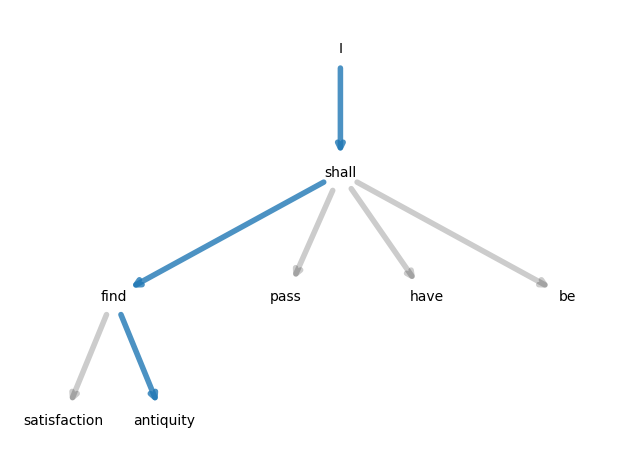

In [ ]:
visualise_mechanism(demo_line, dictionnaire)

#### **Final Remarks**

Is this an AI model? In the broadest sense of those two words, perhaps. But to describe this model as such in a general context, surely, is to stretch the limits of credulity. There is clearly no reinforcement learning going on here.

Could this model be useful for any real-world applications? Well, *how often do you think about the roman empire?*

What would be the next improvements or enhancements you would make to this model? One of the simplest improvements which would have a drastic effect is to increase the length of the input text. This would allow for a more varied response, to the extent that fewer parts of the output would need to be reproduced verbatim from the input for lack of alternatives. Interestingly, we may also begin to see more statistical effects, wherein words which follow a given pair more frequently will also be picked more often as the prediction. Another improvement that can be considered is to increase number of previous words that affect the prediction. Though this must attempted cautiously, since it works against the previous improvement insomuch as it limits the number of possible predictions and decreases the variability of output.

On a final note, the visualisation functions can be quite fragile. Please don't try to break them too hard :)